# Importando librerías

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast

In [18]:
with mlflow.start_run(run_name="Breast Cancer - Colab"):
  mlflow.log_param("Image Size _0_", 480)
  mlflow.log_param("Image Size _1_", 640)
  mlflow.tensorflow.autolog()

# Preprocesamiento

In [19]:
# Agregar image_dataset_from_directory para traer imágenes al código,
# convertirlas (o no) en RGB antes de procesar, se podría asegurar un aspect ratio?

BATCH_SIZE = 32
IMG_SIZE = (480, 640) #(256, 256)
directory = "./dataset"

train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    class_names=["healthy", "sick"],
    color_mode='rgb',
    image_size=IMG_SIZE,
    shuffle=True,
    seed=98,
    validation_split=0.3,
    subset="training",
    interpolation='bilinear',
    crop_to_aspect_ratio=True
)

valid_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='binary',
    class_names=["healthy", "sick"],
    color_mode='rgb',
    image_size=IMG_SIZE,
    shuffle=True,
    seed=98,
    validation_split=0.3,
    subset="validation",
    interpolation='bilinear',
    crop_to_aspect_ratio=True
)

Found 4736 files belonging to 2 classes.
Using 3316 files for training.
Found 4736 files belonging to 2 classes.
Using 1420 files for validation.


In [20]:
# Definimos una función para aumentar nuestros datos.

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.models.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomContrast(factor=[0.05, 0.25]))
    
    return data_augmentation

data_augmentation = data_augmenter()

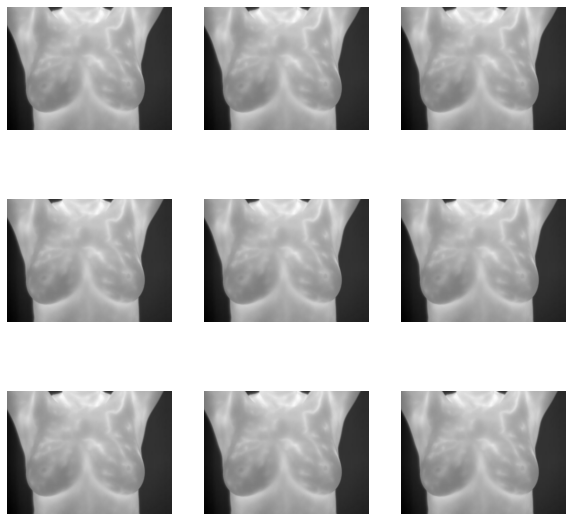

In [21]:
# La aplicamos en train_dataset

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

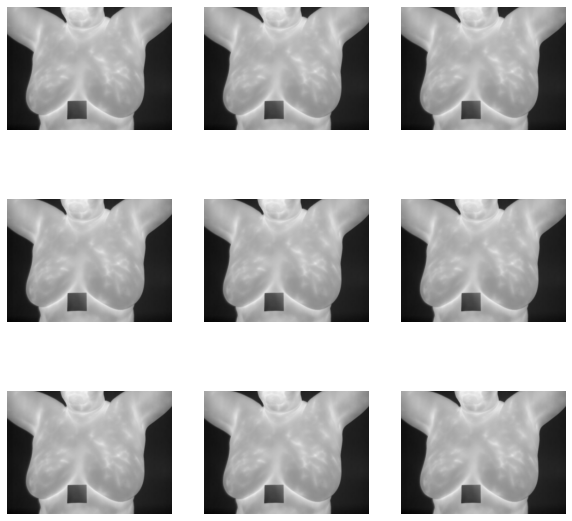

In [22]:
# La aplicamos en valid_dataset

for image, _ in valid_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [23]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Creación del modelo

In [24]:
def breast_cancer_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [25]:
model2 = breast_cancer_model(IMG_SIZE, data_augmentation)

## Hiperparámetros

In [26]:
base_learning_rate = 0.001

model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
callback = EarlyStopping(
    monitor="accuracy",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

mlflow.log_param("patience", 5)
mlflow.log_text('accuracy', "file.txt")

## Entrenamiento

In [ ]:
initial_epochs = 5

history = model2.fit(train_dataset,
                     validation_data=valid_dataset,
                     epochs=initial_epochs,
                     callbacks=[callback])

Epoch 1/5


## Resultados

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("First_train.png")
mlflow.log_artifact("First_train.png")

plt.show()



# Fine Tuning del modelo

In [ ]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300 #120

mlflow.log_param("frozen labels", 300)

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

## Entrenamiento

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

## Resultados

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("Second_train.png")
mlflow.log_artifact("Second_train.png")

plt.show()

# Miscelánea

You're going to undertake the first part of a Coarse to Fine search. This involves analyzing the results of an initial random search that took place over a large search space, then deciding what would be the next logical step to make your hyperparameter search finer.

You have available:

combinations_list - a list of the possible hyperparameter combinations the random search was undertaken on.
results_df - a DataFrame that has each hyperparameter combination and the resulting accuracy of all 500 trials. Each hyperparameter is a column, with the header the hyperparameter name.
visualize_hyperparameter() - a function that takes in a column of the DataFrame (as a string) and produces a scatter plot of this column's values compared to the accuracy scores. An example call of the function would be visualize_hyperparameter('accuracy')
If you wish to view the visualize_hyperparameter() function definition, you can run this code:

import inspect
print(inspect.getsource(visualize_hyperparameter))


Confirm (by printing out) the size of the combinations_list, justifying the need to start with a random search.

Sort the results_df by accuracy values and print the top 10 rows. Are there clear insights? Beware a small sample size!

Confirm (by printing out) which hyperparameters were used in this search. These are the column names in results_df.

Call visualize_hyperparameter() with each hyperparameter in turn (max_depth, min_samples_leaf, learn_rate). Are there any trends?

In [ ]:
# Confirm the size of the combinations_list
print(len(combinations_list))

# Sort the results_df by accuracy and print the top 10 rows
print(results_df.sort_values(by='accuracy', ascending=False).head(10))

# Confirm which hyperparameters were used in this search
print(results_df.columns)

# Call visualize_hyperparameter() with each hyperparameter in turn
visualize_hyperparameter('max_depth')
visualize_hyperparameter('min_samples_leaf')
visualize_hyperparameter('learn_rate')

You will now visualize the first random search undertaken, construct a tighter grid and check the results. You will have available:

results_df - a DataFrame that has the hyperparameter combination and the resulting accuracy of all 500 trials. Only the hyperparameters that had the strongest visualizations from the previous exercise are included (max_depth and learn_rate)
visualize_first() - This function takes no arguments but will visualize each of your hyperparameters against accuracy for your first random search.
If you wish to view the visualize_first() (or the visualize_second()) function definition, you can run this code:

import inspect
print(inspect.getsource(visualize_first))

Use the visualize_first() function to check the values of max_depth and learn_rate that tend to perform better. A convenient red line will be added to make this explicit.

Now create a more narrow grid search, testing for max_depth values between 1 and 20 and for 50 learning rates between 0.001 and 1.

We ran the 1,000 model grid search in the background based on those new combinations. Now use the visualize_second() function to visualize the second iteration (grid search) and see if there is any improved results. This function takes no arguments, just run it in-place to generate the plots!

In [ ]:
# Use the provided function to visualize the first results
# visualize_first()

# Create some combinations lists & combine:
max_depth_list = list(range(1,21))
learn_rate_list = np.linspace(0.001,1,50)

# Call the function to visualize the second results
visualize_second()